In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Imports and Packages

In [ ]:
!pip install nltk
!pip install PyPDF2
!python -m spacy download en_core_web_lg
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 KB 6.8 MB/s eta 0:00:00
2023-03-21 20:29:50.657832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 20:29:51.877181: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-21 20:29:51.877313: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64]

In [ ]:
import toml
import os
import re
import sys
import nltk
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.svm import SVC
import joblib
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential,Model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import keras
import tensorflow as tf

from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import DBSCAN
from keras.utils import to_categorical
from keras.models import Sequential
from matplotlib.gridspec import GridSpec
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer

# Downloads and Dataset Loading

In [ ]:
!gdown 1fTWzR3-AUxmnmnGeHuPpac9QS0msJDje  # Download Dataset
!gdown 1-6_4jE-zJ6Dw3nek2TBcBk3TkxkUF1OL  # Download Skills.jsonl

Downloading...
From: https://drive.google.com/uc?id=1fTWzR3-AUxmnmnGeHuPpac9QS0msJDje
To: /content/UpdatedResumeDataSet.csv
100% 3.11M/3.11M [00:00<00:00, 94.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-6_4jE-zJ6Dw3nek2TBcBk3TkxkUF1OL
To: /content/skills.jsonl
100% 156k/156k [00:00<00:00, 97.1MB/s]


In [ ]:
df = pd.read_csv("/content/UpdatedResumeDataSet.csv")

In [ ]:
df = df[~df.Category.isin(["Arts", "Advocate", "HR"])]

In [ ]:
df = df[~df.duplicated()]

# Data Exploration

## Data Distribution

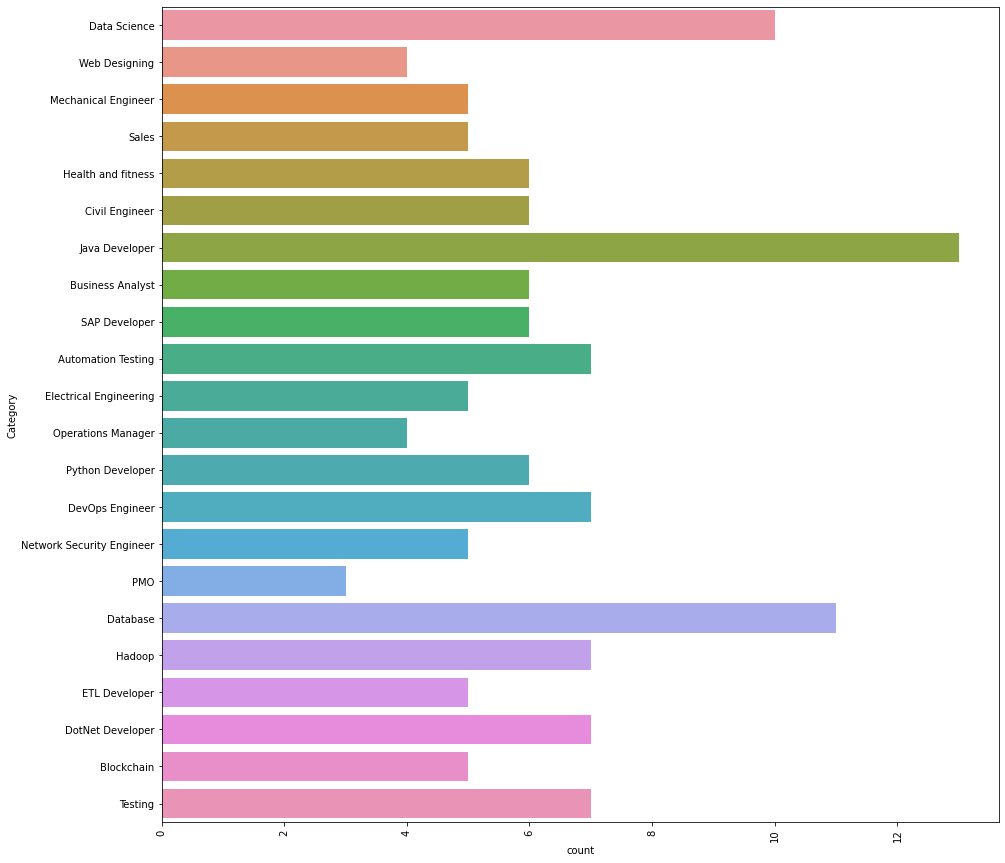

In [ ]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(y="Category", data=df)
plt.show()


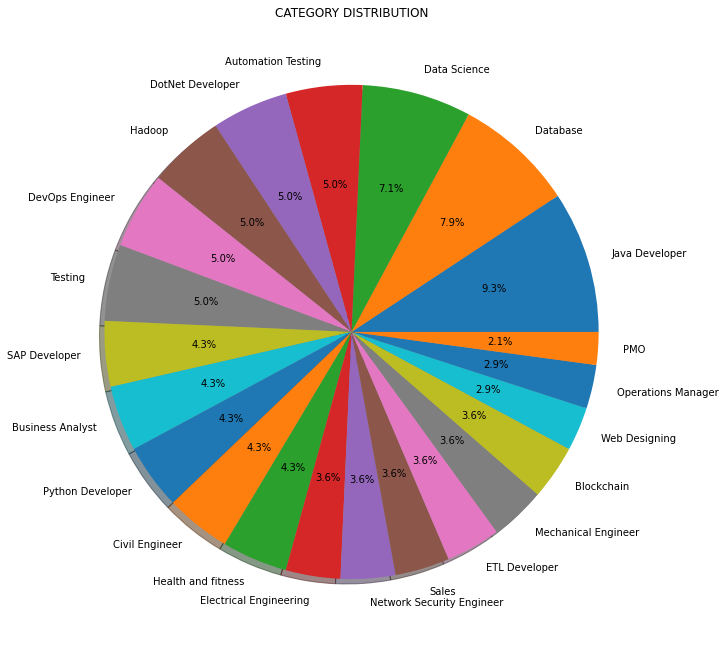

In [ ]:
#Pie-chart
targetCounts = df['Category'].value_counts().reset_index()['Category']
targetLabels  = df['Category'].value_counts().reset_index()['index']
# Make square figures and axes
plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')
source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, )
plt.show()

## Skills

In [ ]:
import spacy

nlp = spacy.load("en_core_web_lg")
skill_pattern_path = "/content/skills.jsonl"

In [ ]:
ruler = nlp.add_pipe("entity_ruler")


In [ ]:
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [ ]:
def get_skills(text):
    doc = nlp(text)
    myset = []
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    myset.append(subset)
    return subset


def unique_skills(x):
    return list(set(x))

In [ ]:
# Define a function to extract the skills from a resume
def extract_skills(resume_text):
    doc = nlp(resume_text.lower())
    skills = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            skills.append(ent.text)
    return skills

# Extract the skills from each resume and add them to the DataFrame
df['Skills'] = df['Resume'].apply(extract_skills)

# Define a function to get the top n skills for each category
def get_top_skills(df, category_col, skill_col, n_top_skills):
    top_skills_df = pd.DataFrame(columns=[category_col, 'Skill', 'Count'])
    for category in df[category_col].unique():
        skills = []
        for lst in df[df[category_col] == category][skill_col]:
            skills += lst
        skill_counts = pd.Series(skills).value_counts()
        top_skills = skill_counts[:n_top_skills].reset_index()
        top_skills.columns = ['Skill', 'Count']
        top_skills[category_col] = category
        top_skills_df = pd.concat([top_skills_df, top_skills], ignore_index=True)
    return top_skills_df

# Get the top 10 skills for each category
top_skills_df = get_top_skills(df, 'Category', 'Skills', 10)

# Print the top skills for each category
for category in df['Category'].unique():
    print(f"\nTop skills for '{category}':")
    print(top_skills_df[top_skills_df['Category'] == category][['Skill', 'Count']])




Top skills for 'Data Science':
              Skill Count
0            python    35
1      data science    32
2         analytics    29
3  machine learning    26
4          business    14
5               nlp    13
6     deep learning    11
7        algorithms    11
8          database    10
9       engineering     9

Top skills for 'Web Designing':
           Skill Count
10     bootstrap    14
11        jquery    13
12      software    13
13      database    10
14    javascript     6
15        design     4
16       windows     3
17       angular     2
18   text editor     2
19  sublime text     2

Top skills for 'Mechanical Engineer':
                     Skill Count
20                  design    20
21             engineering    12
22  mechanical engineering     8
23                 support     5
24                material     3
25           specification     3
26               marketing     2
27                schedule     2
28                software     2
29     engineering drawing 

In [ ]:
joblib.dump(top_skills_df, f"/content/drive/MyDrive/Colab Notebooks/Data-Science-Intro/top_skills.joblib")

['/content/drive/MyDrive/Colab Notebooks/Data-Science-Intro/top_skills.joblib']

# Preprocessing


## Remove Unwanted Words and Lower Text

In [ ]:
def clean_resume(resumeText: str):
    resumeText = resumeText.encode("ascii", "ignore").decode("ascii")
    resumeText = re.sub('httpS+s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub(r"\b\d{4}\b", "", resumeText)  # Remove years
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"$%&'()*+,-./:;<=>?@[]^_{|}~""").replace("\!", ""), ' ', resumeText)
    resumeText = re.sub(r'\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText.lower()

df['cleaned_resume'] = df.Resume.apply(clean_resume)

## Encode Categories

In [ ]:
var_mod = ['Category']
df["Labeled_Category"] = df[var_mod].apply(LabelEncoder().fit_transform)


## NLTK Preprocessing

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')


# Remove stop words
stop_words = set(stopwords.words('english'))
df['cleaned_resume'] = df['cleaned_resume'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# # Stem the words
stemmer = SnowballStemmer('english')
df['cleaned_resume'] = df['cleaned_resume'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Remove words that appear in all classes
cv = CountVectorizer()
word_counts = cv.fit_transform(df['cleaned_resume'])
word_counts_df = pd.DataFrame(word_counts.toarray(), columns=list(cv.get_feature_names_out()))
word_counts_df['category'] = df['Category']
words_in_all_classes = set(word_counts_df.drop('category', axis=1).columns[word_counts_df.drop('category', axis=1).sum(axis=0) == len(word_counts_df)])
df['cleaned_resume'] = df['cleaned_resume'].apply(lambda x: ' '.join([word for word in x.split() if word not in words_in_all_classes]))

# Create a list of blacklisted words to remove from cleaned resumes
blacklist = ['year', 'experience', 'month', 'detail', 'experienc']

# Remove blacklisted words from cleaned resumes
df['cleaned_resume'] = df['cleaned_resume'].apply(lambda x: ' '.join([word for word in x.split() if word not in blacklist]))




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


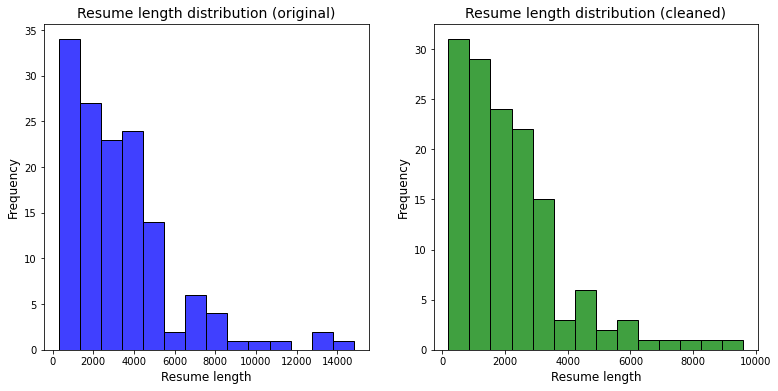

In [ ]:
df['length'] = df['Resume'].str.len()
df['length_Clean'] = df['cleaned_resume'].str.len()

# Plot the distributions
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 6))

# Plot the original resume length distribution in blue
sns.histplot(df['length'], ax=ax1, color='blue', kde=False)
ax1.set_title('Resume length distribution (original)', fontsize=14)
ax1.set_xlabel('Resume length', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)

# Plot the cleaned resume length distribution in green
sns.histplot(df['length_Clean'], ax=ax2, color='green', kde=False)
ax2.set_title('Resume length distribution (cleaned)', fontsize=14)
ax2.set_xlabel('Resume length', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)

# Show the plot
plt.show()

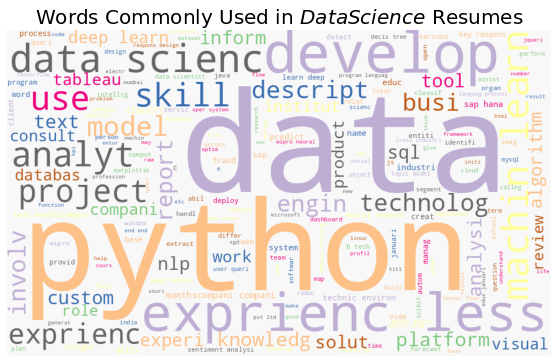

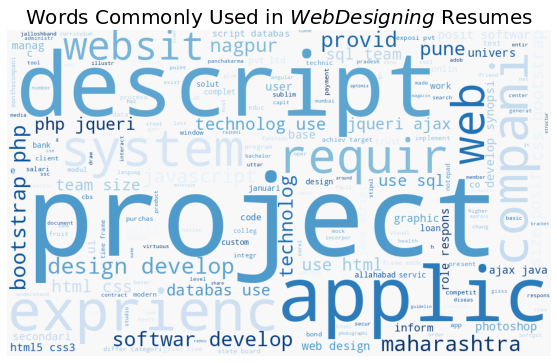

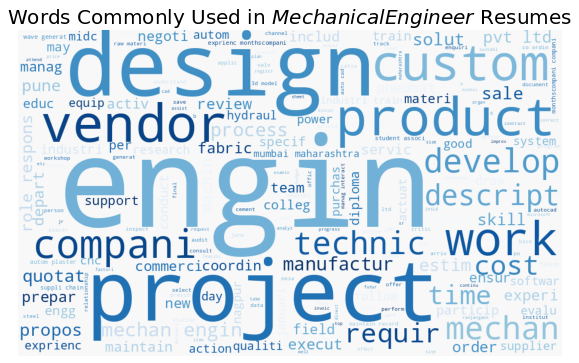

In [ ]:
a=[ 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r','BrBG_r', 'BuGn', 'BuGn_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'crest_r']
for label, cmap in zip(df['Category'].unique()[:3], a):
    text = df.query("Category == @label")["cleaned_resume"].str.cat(sep=" ")
    plt.figure(figsize=(10, 6))
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Resumes", size=20)
    plt.show()

# Traning

## Classic: XGBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_resume'], df['Labeled_Category'], test_size=0.2)

In [ ]:
# Create a CountVectorizer object
cv = CountVectorizer(max_features=5000)

# Fit and transform the training data
X_train_counts = cv.fit_transform(X_train)

# Transform the testing data
X_test_counts = cv.transform(X_test)

In [ ]:
# Create an XGBoost classifier object
xgb = XGBClassifier(n_estimators=15, max_leaves=5, verbosity=1, n_jobs=-1)

# Train the classifier on the training data
xgb.fit(X_train_counts, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=5,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=15, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
# Evaluate the performance of the classifier on the testing data
y_pred_test = xgb.predict(X_test_counts)
accuracy = accuracy_score(y_test, y_pred_test)

print('Accuracy:', accuracy)

Accuracy: 0.7857142857142857


## Neural Network: LSTM

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = lambda name: keras.callbacks.ModelCheckpoint(f"/content/drive/MyDrive/Colab Notebooks/Data-Science-Intro/{name}", save_best_only=True)

In [ ]:
import os
import re
import sys
import nltk
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.svm import SVC
from joblib import dump, load
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential,Model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.layers import Dense,LSTM, SpatialDropout1D, Embedding
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import DBSCAN
from keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# define the maximum number of words to keep
max_words = 10000

# define the maximum length of the input sequences
max_len = 100

# define the input data


# create a tokenizer object
tokenizer = Tokenizer(num_words=max_words)

# fit the tokenizer on the input data
tokenizer.fit_on_texts(X_train)

# convert the input data to sequences
sequences = tokenizer.texts_to_sequences(X_train)

# pad the sequences to the maximum length
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# define the labels
labels = [1, 0]

# convert the labels to a numpy array
# labels = tf.keras.utils.to_categorical(df.Category)

# define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, 64, input_length=max_len),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
model.fit(padded_sequences, y_train, epochs=10, batch_size=8)

Epoch 1/10
14/14 [==============================] - 10s 184ms/step - loss: nan - accuracy: 0.0536
Epoch 2/10
14/14 [==============================] - 7s 466ms/step - loss: nan - accuracy: 0.0536
Epoch 3/10
14/14 [==============================] - 2s 170ms/step - loss: nan - accuracy: 0.0536
Epoch 4/10
14/14 [==============================] - 2s 112ms/step - loss: nan - accuracy: 0.0536
Epoch 5/10
14/14 [==============================] - 1s 86ms/step - loss: nan - accuracy: 0.0536
Epoch 6/10
14/14 [==============================] - 2s 126ms/step - loss: nan - accuracy: 0.0536
Epoch 7/10
14/14 [==============================] - 1s 85ms/step - loss: nan - accuracy: 0.0536
Epoch 8/10
14/14 [==============================] - 1s 59ms/step - loss: nan - accuracy: 0.0536
Epoch 9/10
14/14 [==============================] - 1s 46ms/step - loss: nan - accuracy: 0.0536
Epoch 10/10
14/14 [==============================] - 1s 57ms/step - loss: nan - accuracy: 0.0536


## Upload new CV

In [ ]:
!gdown 1uPTycE0w0za9TGj4AfN9I6vhxkjcl8BO

Downloading...
From: https://drive.google.com/uc?id=1uPTycE0w0za9TGj4AfN9I6vhxkjcl8BO
To: /content/LTSM.h5
100% 9.33M/9.33M [00:00<00:00, 59.0MB/s]


In [ ]:
lstm = keras.models.load_model("/content/LTSM.h5")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Hai Arbiv - Resume 2021.pdf to Hai Arbiv - Resume 2021 (1).pdf


In [ ]:
import PyPDF2
# Get filename of uploaded CV
cv_filename = next(iter(uploaded))

# Open uploaded CV as PDF and extract text
with open(cv_filename, 'rb') as cv_file:
    pdf_reader = PyPDF2.PdfReader(cv_file)
    cv_text = ''
    for page in range(len(pdf_reader.pages)):
        cv_text += pdf_reader.pages[page].extract_text()

In [ ]:
le = LabelEncoder()
le.fit(df.Category)

LabelEncoder()

In [ ]:
max_len = 150
tokenizer = Tokenizer(max_len)
cv_text = clean_resume(cv_text)
sequence = tokenizer.texts_to_sequences([cv_text])
padded_sequence = pad_sequences(sequence, maxlen=max_len)
proba = lstm.predict(padded_sequence)
lstm_category_encoded = np.argmax(proba, axis=1)
lstm_category = le.inverse_transform(lstm_category_encoded)[0]
lstm_category

1/1 [==============================] - 0s 82ms/step


'Testing'

In [ ]:
!gdown 1CDLuw9B_mekPn9-uLOeTQGuCPZHflLiC

Downloading...
From: https://drive.google.com/uc?id=1CDLuw9B_mekPn9-uLOeTQGuCPZHflLiC
To: /content/xgb.joblib
100% 266k/266k [00:00<00:00, 94.0MB/s]


In [ ]:
xgb = joblib.load("xgb.joblib")

In [ ]:
import PyPDF2
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import base64
from IPython.display import HTML
from IPython.core.display import HTML
from IPython.display import FileLink
from google.colab import files

# Prompt user to upload CV file
uploaded = files.upload()

# Get filename of uploaded CV
cv_filename = next(iter(uploaded))

# Open uploaded CV as PDF and extract text
with open(cv_filename, 'rb') as cv_file:
    pdf_reader = PyPDF2.PdfReader(cv_file)
    cv_text = ''
    for page in range(len(pdf_reader.pages)):
        cv_text += pdf_reader.pages[page].extract_text()

cv_text = clean_resume(cv_text)

# Convert the text into numerical features
text_counts = cv.transform([cv_text])

# Use the trained XGBoost classifier to predict the category of the new CV
predicted_category_encoded = xgb.predict(text_c ounts)
predicted_category = le.inverse_transform(predicted_category_encoded)

# Clean the text and predict the category using the XGBoost classifier

X_counts = cv.transform([cv_text])
# xgb_category = le.inverse_transform(xgb.predict(X_counts))[0]

# Tokenize and pad the text and predict the category using the LSTM model
# tokenizer = tf.keras.preprocessing.text.Tokenizer(
#     num_words=150
# )

# sequence = tokenizer.texts_to_sequences([cv_text])
# padded_sequence = keras.utils.pad_sequences(
#     sequence,
#     maxlen=150
# )
# proba = lstm.predict(padded_sequence)
# lstm_category_encoded = np.argmax(proba, axis=1)
# lstm_category = le.inverse_transform(lstm_category_encoded)[0]

print('XGBoost category:', predicted_category)
# print('LSTM category:', lstm_category)


def extract_skills(resume_text, top_skills_df, category):
    doc = nlp(cv_text)
    skills = set()  # Use a set to prevent duplicates
    for ent in doc.ents:
        if ent.label_ == "SKILL" and ent.text in top_skills_df[top_skills_df['Category'] == category]['Skill'].tolist():
            skills.add(ent.text)  # Use set.add() to avoid duplicates
    return list(skills)  # Convert set back to a list before returning it


# Predict the category of the new CV using the XGBoost classifier

X_counts = cv.transform([cv_text])
xgb_category = le.inverse_transform(xgb.predict(X_counts))[0]

# Get the top skills for the predicted category
top_skills_df = get_top_skills(df, 'Category', 'Skills', 10)
top_skills_category = top_skills_df[top_skills_df['Category'] == xgb_category]

# Extract the skills from the new CV that are in the top skills for the predicted category
new_cv_skills = extract_skills(text, top_skills_category, xgb_category)

# Print the filtered skills
print('The relevnt skills in your CV:')
print(new_cv_skills)

# Get the recommended skills to add for the predicted category
recommended_skills = top_skills_category['Skill'].tolist()

# Remove the skills that are already present in the new CV
recommended_skills = [skill for skill in recommended_skills if skill not in new_cv_skills]

# Print the recommended skills to add
print('\nRecommended skills to add:')
print(recommended_skills)



Saving GilChenPythonDeveloperResume.pdf to GilChenPythonDeveloperResume.pdf
XGBoost category: ['Python Developer']
The relevnt skills in your CV:
['design', 'python', 'testing']

Recommended skills to add:
['mysql', 'django', 'support', 'git', 'java', 'mongodb', 'numpy']
